<a href="https://colab.research.google.com/github/meleeshagamage/CourseWork_ML/blob/main/ML_CW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TASK 1

In [1]:
# Import the libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.tree import plot_tree
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report



print("Libraries loaded")

Libraries loaded


In [2]:
#Mount the google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Import the dataset
df = pd.read_csv('/content/drive/MyDrive/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
#Get the shape
print("Shape:", df.shape)
df.info()

Shape: (7043, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 n

In [5]:
# Convert TotalCharges to numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [6]:
#Count Missing Values
print("Missing values after cleaning:")
print(df.isnull().sum())

Missing values after cleaning:
customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64


### EDA visualizations


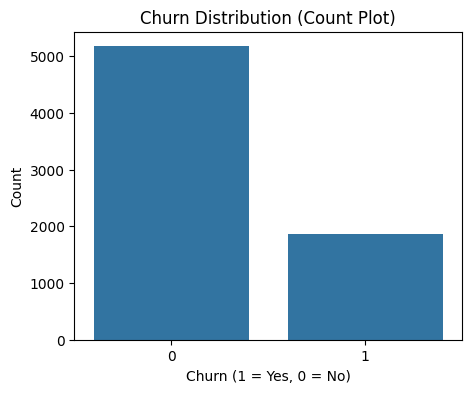

In [7]:
# Convert churn columnif needed
df['Churn_numeric'] = df['Churn'].map({'Yes':1, 'No':0})

# Plot 'Churn' feature
plt.figure(figsize=(5,4))
sns.countplot(x='Churn_numeric', data=df)
plt.title('Churn Distribution (Count Plot)')
plt.xlabel('Churn (1 = Yes, 0 = No)')
plt.ylabel('Count')
plt.show()



Numeric cols: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'Churn_numeric']


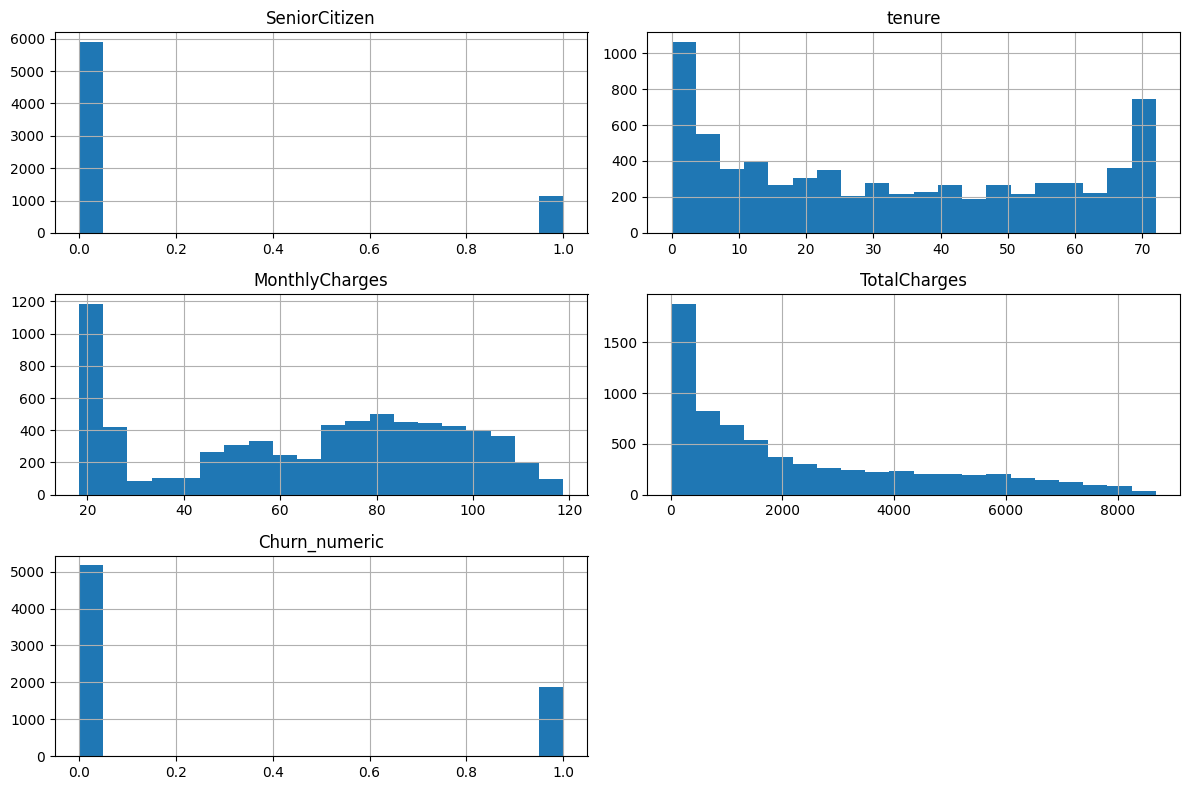

In [8]:
# Numeric columns histograms
num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
print("Numeric cols:", num_cols)
df[num_cols].hist(bins=20, figsize=(12,8))
plt.tight_layout()
plt.show()

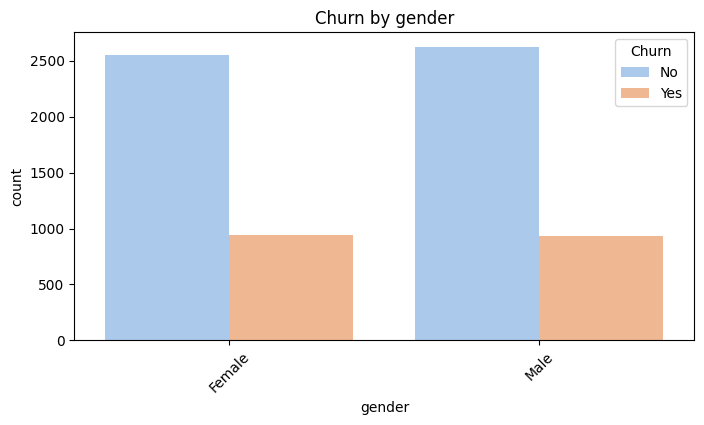

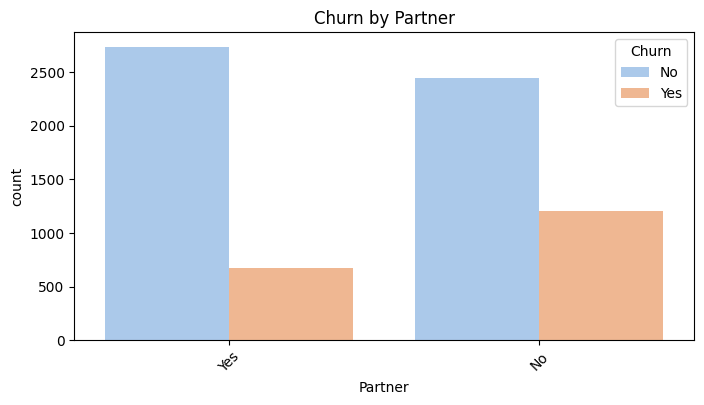

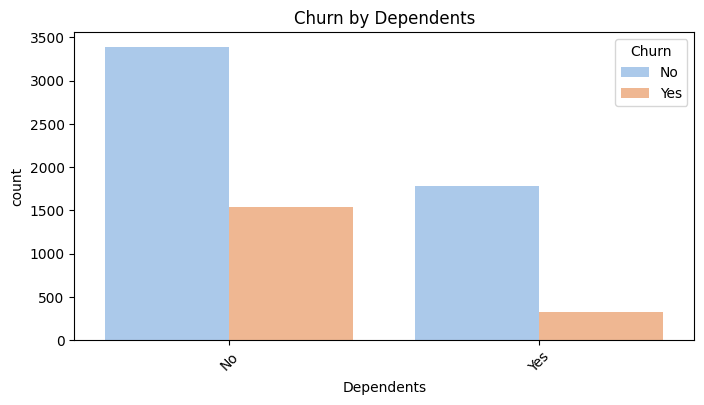

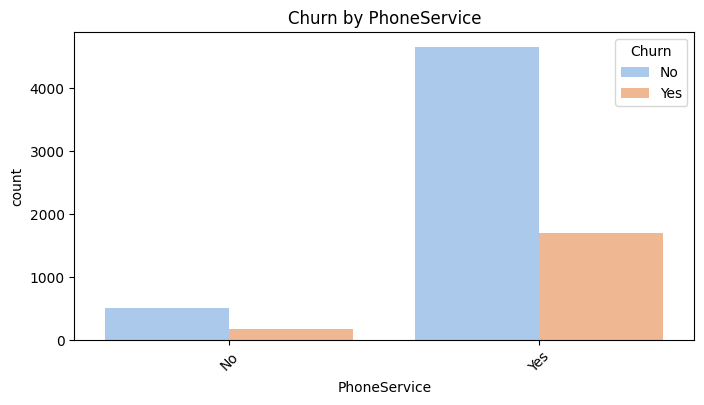

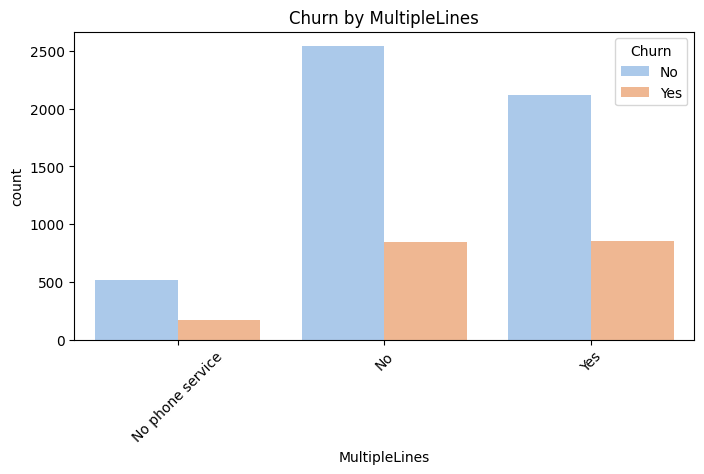

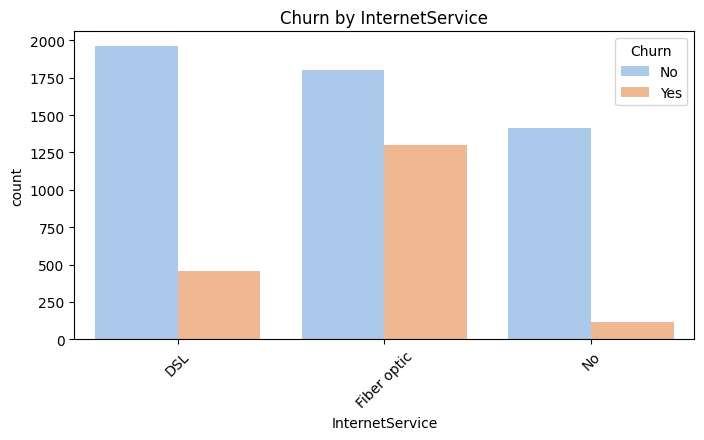

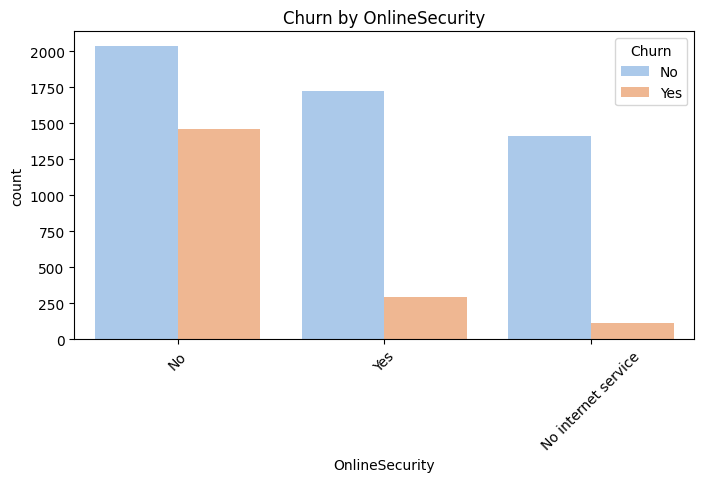

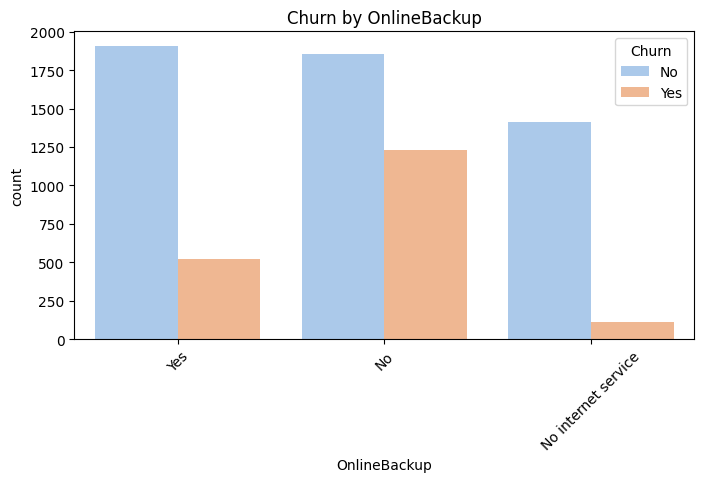

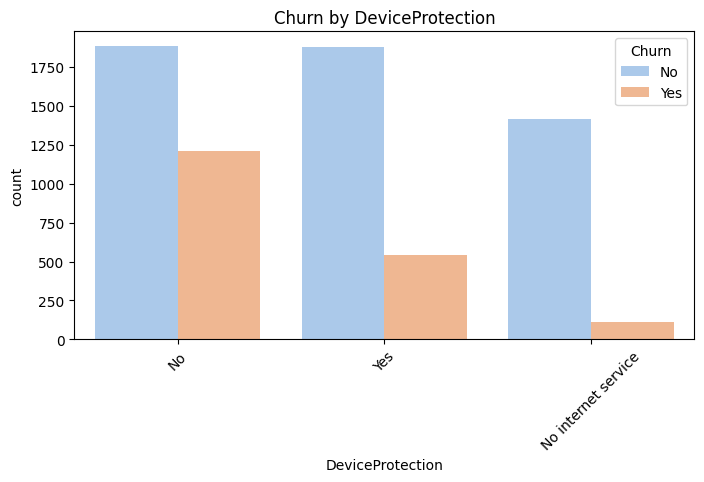

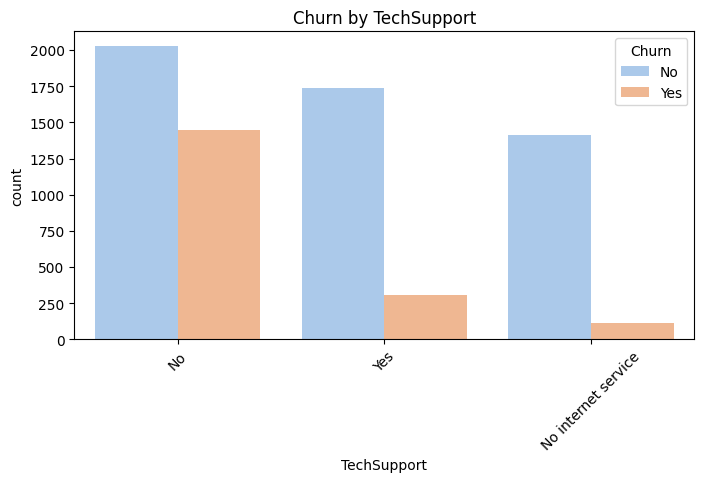

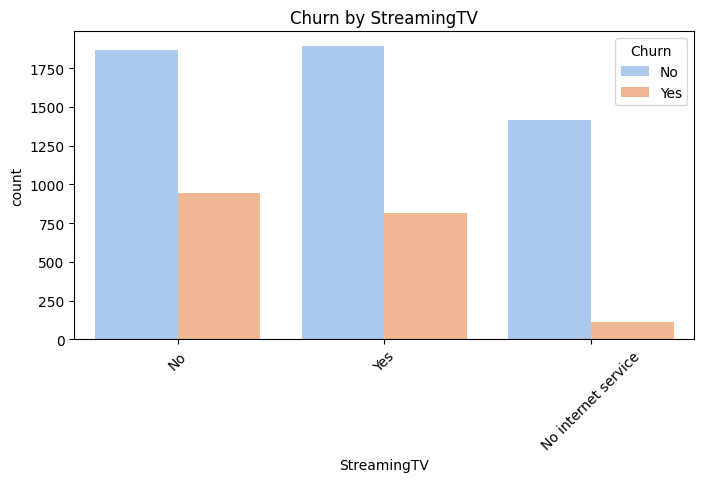

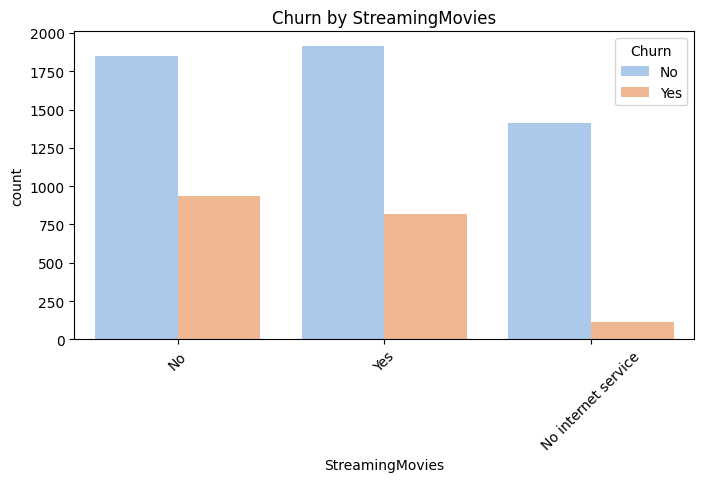

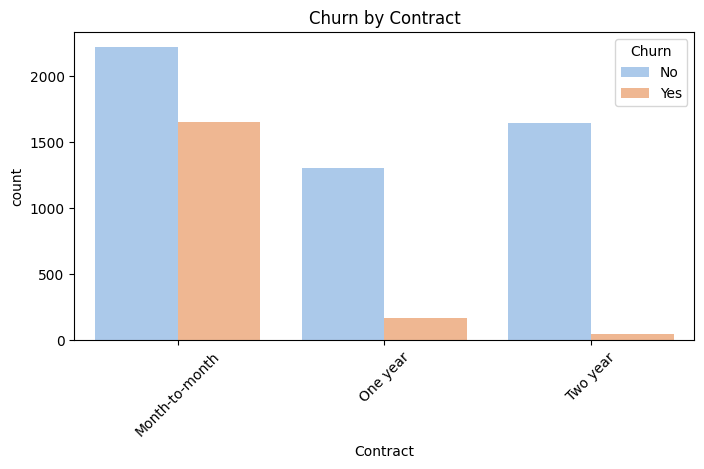

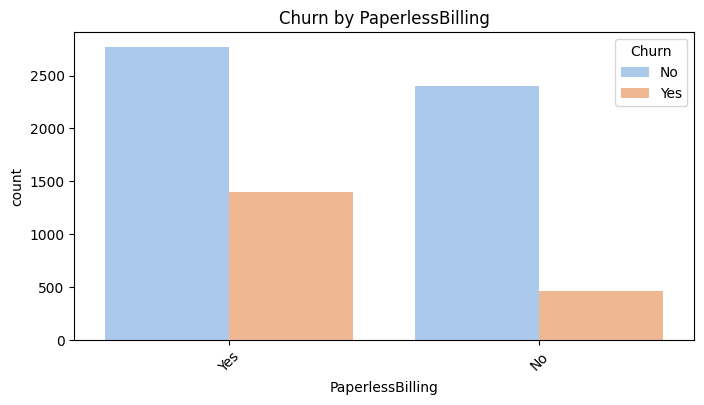

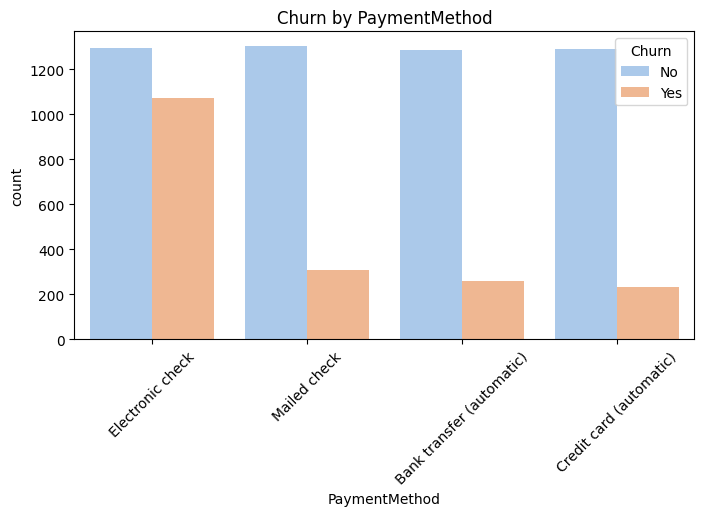

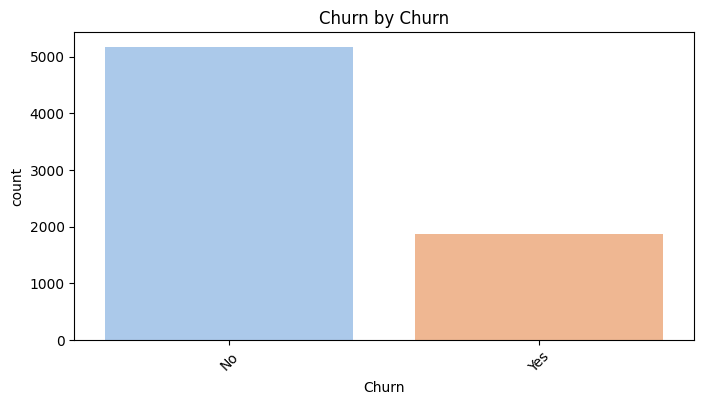

In [9]:
# Categorical colunms distributions
categorical_cols = df.select_dtypes(include=['object']).columns.drop('customerID')

for col in categorical_cols:
    plt.figure(figsize=(8,4))
    sns.countplot(x=col, hue='Churn', data=df, palette='pastel')
    plt.title(f'Churn by {col}')
    plt.xticks(rotation=45)
    plt.show()


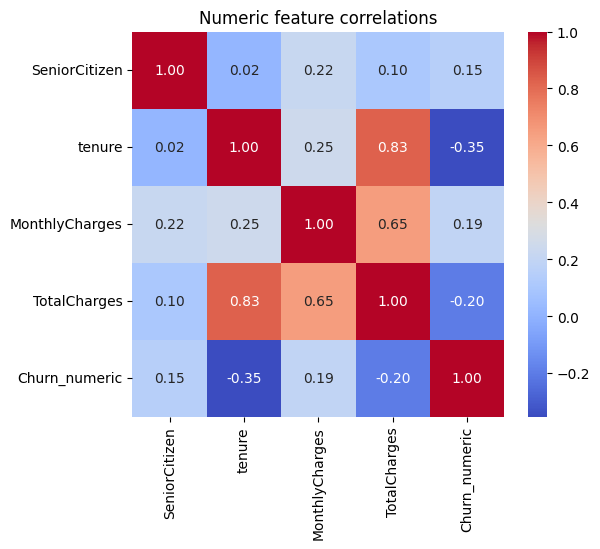

In [10]:
# Correlation heatmap among numeric features
plt.figure(figsize=(6,5))
sns.heatmap(df[num_cols].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Numeric feature correlations')
plt.show()

### Data Cleaning

In [11]:
# Drop 'customerID' column
df = df.drop(columns=['customerID'], errors='ignore')

In [12]:
# Fill missing va;ues with Median
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

/tmp/ipython-input-1482820520.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)


In [13]:
# Drop 'Churn_numeric' feature
df = df.drop(columns=['Churn_numeric'], errors='ignore')

In [14]:
# Encode target
df['Churn'] = df['Churn'].map({'Yes':1,'No':0})

### Train-test split

In [17]:
# Split Data
y = df['Churn']
X = df.drop(columns=['Churn'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [18]:
# After spliting the data
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (5634, 19)
X_test shape: (1409, 19)
y_train shape: (5634,)
y_test shape: (1409,)


In [19]:
# Check class distribution is maintained
print(f"\nOriginal churn ratio: {df['Churn'].value_counts(normalize=True)}")
print(f"Train churn ratio: {y_train.value_counts(normalize=True)}")
print(f"Test churn ratio: {y_test.value_counts(normalize=True)}")


Original churn ratio: Churn
0    0.73463
1    0.26537
Name: proportion, dtype: float64
Train churn ratio: Churn
0    0.734647
1    0.265353
Name: proportion, dtype: float64
Test churn ratio: Churn
0    0.734564
1    0.265436
Name: proportion, dtype: float64


### Processing the Data

In [20]:
# After splitting, identify columns from trainig data only
numeric_features = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X_train.select_dtypes(include=["object"]).columns.tolist()


print("Numeric features for preprocessing:", numeric_features)
print("Categorical features for preprocessing:", categorical_features)

Numeric features for preprocessing: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
Categorical features for preprocessing: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']


In [21]:
# Build the preprocessing pipeline

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

#
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop='first'))

])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ],
    remainder="drop"
)

# TASK 2

### Decision Tree with hyperparameter tuning

In [22]:
dt_pipeline = Pipeline(steps=[
    ("preproc", preprocessor),
    ("clf", DecisionTreeClassifier(random_state=42))
])

In [23]:
# Tunes the decision‑tree pipeline’s hyperparameters

param_grid = {
    'clf__criterion': ['gini', 'entropy'],
    'clf__max_depth': [3, 5, 8, 12, None],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4],
    'clf__class_weight': [None, 'balanced']
}

grid_dt = GridSearchCV(
    dt_pipeline,
    param_grid,
    cv=5,
    scoring="f1",
    n_jobs=-1,
    verbose=1
)


grid_dt.fit(X_train, y_train)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preproc',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['SeniorCitizen',
                                                                          'tenure',
                                                                          'MonthlyCharges',
                                                                          'TotalCharges']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(drop='...
                                                                          'StreamingTV',
                                                                          'StreamingMovies',
                                                                          'Contract',
                                                                          'PaperlessBilling',
                                                                          'PaymentMethod'])])),
                                       ('clf',
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__class_weight': [None, 'balanced'],
                         'clf__criterion': ['gini', 'entropy'],
                         'clf__max_depth': [3, 5, 8, 12, None],
                         'clf__min_samples_leaf': [1, 2, 4],
                         'clf__min_samples_split': [2, 5, 10]},
             scoring='f1', verbose=1)

In [24]:
# Get best hyperparameters found
print("Best Decision Tree parameters:")
print(grid_dt.best_params_)
print("\nBest CV F1-score (training CV):")
print(grid_dt.best_score_)

Best Decision Tree parameters:
{'clf__class_weight': 'balanced', 'clf__criterion': 'entropy', 'clf__max_depth': 8, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 5}

Best CV F1-score (training CV):
0.6111844563666912


In [25]:
best_dt = grid_dt.best_estimator_
y_pred_dt = best_dt.predict(X_test)
y_proba_dt = best_dt.predict_proba(X_test)[:, 1]


In [26]:
print("\n  TEST RESULTS ")
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print("Precision:", precision_score(y_test, y_pred_dt))
print("Recall:", recall_score(y_test, y_pred_dt))
print("F1:", f1_score(y_test, y_pred_dt))
print("ROC AUC:", roc_auc_score(y_test, y_proba_dt))

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_dt))


  TEST RESULTS 
Accuracy: 0.7324343506032647
Precision: 0.4975609756097561
Recall: 0.8181818181818182
F1: 0.6188068756319515
ROC AUC: 0.8211165362060502

Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.70      0.79      1035
           1       0.50      0.82      0.62       374

    accuracy                           0.73      1409
   macro avg       0.71      0.76      0.71      1409
weighted avg       0.80      0.73      0.75      1409



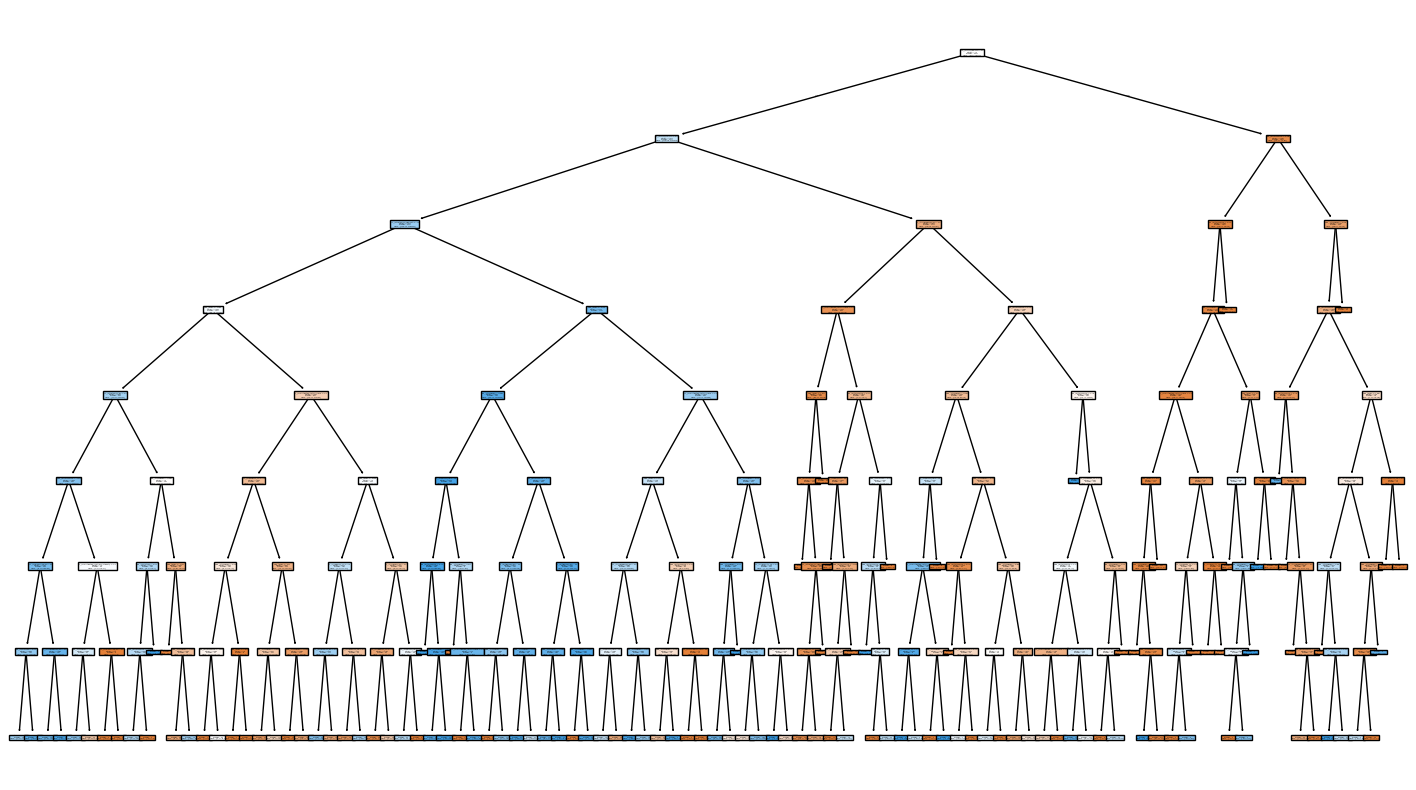

In [27]:
# Plot Decision Tree
feature_names = best_dt.named_steps["preproc"].get_feature_names_out()

plt.figure(figsize=(18,10))
plot_tree(
    best_dt.named_steps["clf"],
    feature_names=feature_names,
    filled=True,
)
plt.show()


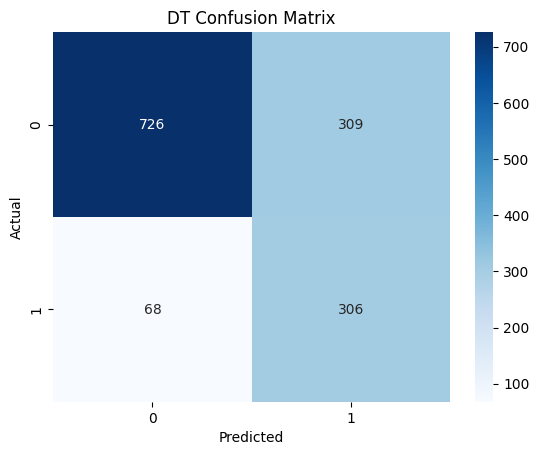

In [28]:
# Plot Confusion_matrix
cm = confusion_matrix(y_test, y_pred_dt)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('DT Confusion Matrix')
plt.show()

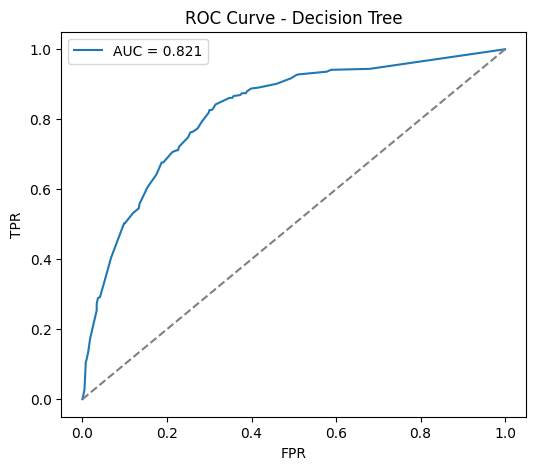

In [29]:
# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba_dt)
auc_score = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.3f}")
plt.plot([0,1],[0,1],"--", color="gray")
plt.title("ROC Curve - Decision Tree")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.show()


In [30]:
# Pruning

# Extract preprocessed training & test data from the pipeline
X_train_pp = best_dt.named_steps['preproc'].transform(X_train)
X_test_pp  = best_dt.named_steps['preproc'].transform(X_test)

# Extract the raw decision tree classifier
clf_unpruned = best_dt.named_steps['clf']


In [31]:
path = clf_unpruned.cost_complexity_pruning_path(X_train_pp, y_train)
ccp_alphas = path.ccp_alphas


In [32]:
clfs = []
for alpha in ccp_alphas:
    model = DecisionTreeClassifier(random_state=42, ccp_alpha=alpha, class_weight=best_dt.named_steps['clf'].class_weight)
    model.fit(X_train_pp, y_train)
    clfs.append(model)

# Evaluate each model on test set
test_scores = [model.score(X_test_pp, y_test) for model in clfs]

best_index = test_scores.index(max(test_scores))
best_alpha = ccp_alphas[best_index]
print("\nBest alpha for pruning:", best_alpha)


Best alpha for pruning: 0.0007872655924971094


In [33]:
pruned_dt = DecisionTreeClassifier(random_state=42, ccp_alpha=best_alpha)
pruned_dt.fit(X_train_pp, y_train)


DecisionTreeClassifier(ccp_alpha=np.float64(0.0007872655924971094),
                       random_state=42)

In [34]:
y_pred_pruned = pruned_dt.predict(X_test_pp)

print("Pruned Decision Tree Performance:")
print(classification_report(y_test, y_pred_pruned))


Pruned Decision Tree Performance:
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1035
           1       0.63      0.54      0.58       374

    accuracy                           0.79      1409
   macro avg       0.74      0.71      0.72      1409
weighted avg       0.79      0.79      0.79      1409



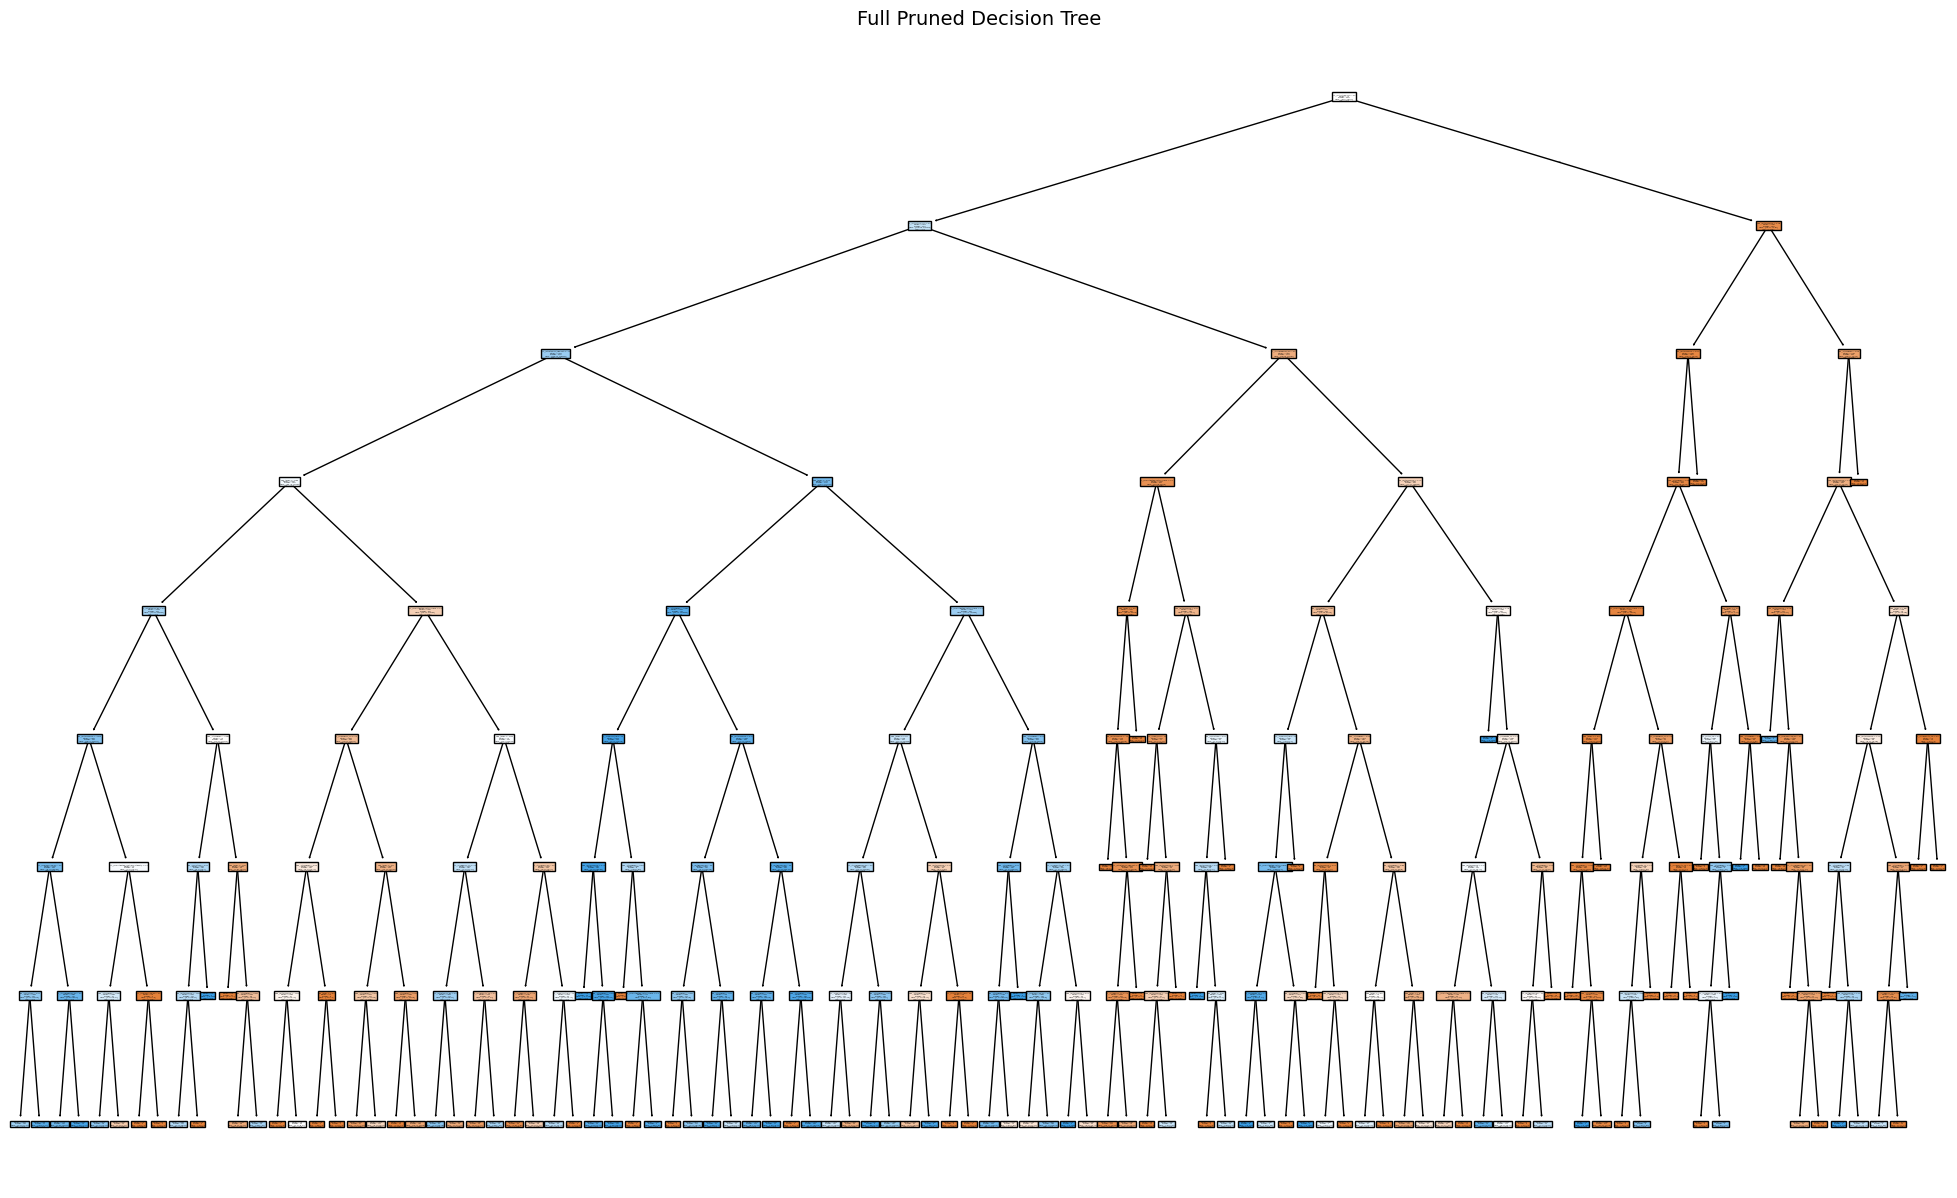

In [35]:
# Plot Pruned Decision Tree
plt.figure(figsize=(25, 15))
plot_tree(
    best_dt.named_steps["clf"],
    feature_names=feature_names,
    class_names=['No Churn', 'Churn'],
    filled=True,

)
plt.title("Full Pruned Decision Tree", fontsize=14)
plt.show()

### Neural Network

In [44]:
# Preprocess data using  existing preprocessor
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed  = preprocessor.transform(X_test)


X_train_np = X_train_processed.toarray() if hasattr(X_train_processed, "toarray") else X_train_processed
X_test_np  = X_test_processed.toarray()  if hasattr(X_test_processed, "toarray")  else X_test_processed

y_train_np = y_train.values
y_test_np  = y_test.values

input_dim = X_train_np.shape[1]
print("Input dimension for ANN:", input_dim)


Input dimension for ANN: 30


In [45]:
def build_and_train_nn(units, layers_count, dropout, epochs=30, batch_size=64):
    model = Sequential()

    # Input and first hidden layer
    model.add(Dense(units, activation="relu", input_dim=input_dim))
    if dropout > 0:
        model.add(Dropout(dropout))

    # Additional hidden layers
    for i in range(layers_count - 1):
        model.add(Dense(units, activation="relu"))
        if dropout > 0:
            model.add(Dropout(dropout))

    # Output
    model.add(Dense(1, activation="sigmoid"))

    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    es = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

    history = model.fit(
        X_train_np, y_train_np,
        validation_split=0.2,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[es],
        verbose=0
    )

    y_pred_prob = model.predict(X_test_np).ravel()
    y_pred = (y_pred_prob >= 0.5).astype(int)
    acc = accuracy_score(y_test_np, y_pred)

    return model, acc, history


In [46]:
tuning_results = []

for units in [32, 64]:
    for layers_count in [1, 2]:
        for dropout in [0.0, 0.3]:
            model, acc, _ = build_and_train_nn(units, layers_count, dropout)

            tuning_results.append({
                'units': units,
                'layers': layers_count,
                'dropout': dropout,
                'accuracy': acc
            })
            print(f"units={units}, layers={layers_count}, dropout={dropout} → accuracy={acc:.4f}")


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
units=32, layers=1, dropout=0.0 → accuracy=0.8027


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
units=32, layers=1, dropout=0.3 → accuracy=0.8034


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
units=32, layers=2, dropout=0.0 → accuracy=0.7935


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
units=32, layers=2, dropout=0.3 → accuracy=0.7963


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
units=64, layers=1, dropout=0.0 → accuracy=0.7977


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
units=64, layers=1, dropout=0.3 → accuracy=0.7970


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
units=64, layers=2, dropout=0.0 → accuracy=0.7935


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
units=64, layers=2, dropout=0.3 → accuracy=0.7977


In [47]:
best_config = max(tuning_results, key=lambda x: x['accuracy'])
best_config


{'units': 32, 'layers': 1, 'dropout': 0.3, 'accuracy': 0.8034066713981547}

In [48]:
best_units = best_config['units']
best_layers = best_config['layers']
best_dropout = best_config['dropout']

print("Training final ANN with:", best_config)

final_model, _, history_obj = build_and_train_nn(
    units=best_units,
    layers_count=best_layers,
    dropout=best_dropout,
    epochs=60,
    batch_size=32
)



Training final ANN with: {'units': 32, 'layers': 1, 'dropout': 0.3, 'accuracy': 0.8034066713981547}


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


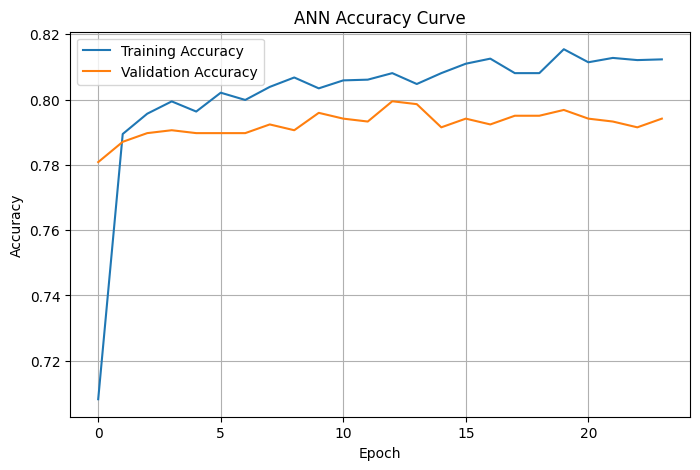

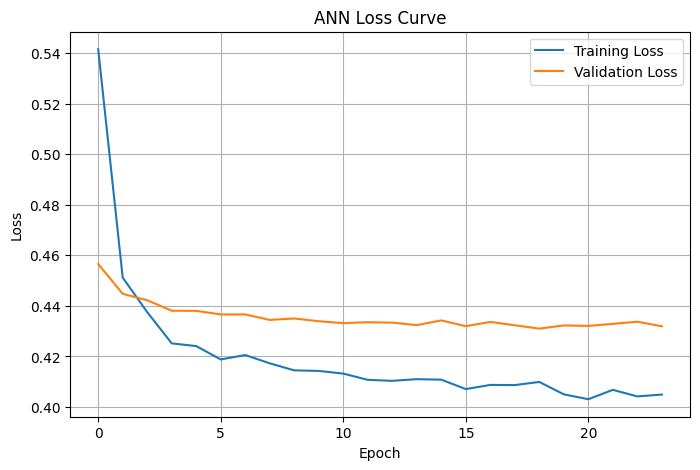

In [50]:
# Accuracy plot
plt.figure(figsize=(8,5))
plt.plot(history_obj.history['accuracy'], label='Training Accuracy')
plt.plot(history_obj.history['val_accuracy'], label='Validation Accuracy')
plt.title("ANN Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Loss plot
plt.figure(figsize=(8,5))
plt.plot(history_obj.history['loss'], label='Training Loss')
plt.plot(history_obj.history['val_loss'], label='Validation Loss')
plt.title("ANN Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


In [51]:

y_pred_prob = final_model.predict(X_test_np).ravel()
y_pred = (y_pred_prob >= 0.5).astype(int)

print("Final ANN Evaluation:")
print("Accuracy:", accuracy_score(y_test_np, y_pred))
print("Precision:", precision_score(y_test_np, y_pred))
print("Recall:", recall_score(y_test_np, y_pred))
print("F1 Score:", f1_score(y_test_np, y_pred))
print("ROC-AUC:", roc_auc_score(y_test_np, y_pred_prob))
print("\nClassification Report:\n")
print(classification_report(y_test_np, y_pred))


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Final ANN Evaluation:
Accuracy: 0.794180269694819
Precision: 0.6409395973154363
Recall: 0.5106951871657754
F1 Score: 0.5684523809523809
ROC-AUC: 0.840943966519414

Classification Report:

              precision    recall  f1-score   support

           0       0.84      0.90      0.86      1035
           1       0.64      0.51      0.57       374

    accuracy                           0.79      1409
   macro avg       0.74      0.70      0.72      1409
weighted avg       0.78      0.79      0.79      1409



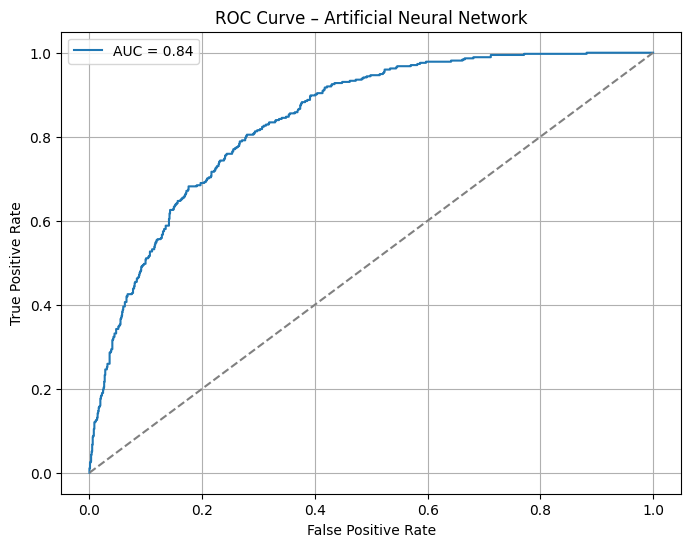

In [52]:
fpr, tpr, _ = roc_curve(y_test_np, y_pred_prob)
roc_value = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_value:.2f}")
plt.plot([0,1],[0,1],'--',color='grey')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Artificial Neural Network")
plt.legend()
plt.grid(True)
plt.show()


### Evaluation  

In [53]:
dt_model = best_dt

# ANN Predictions
y_pred_prob_nn = final_model.predict(X_test_np).ravel()
y_pred_nn = (y_pred_prob_nn >= 0.5).astype(int)

# Decision Tree Predictions
y_pred_dt = dt_model.predict(X_test)
y_pred_prob_dt = dt_model.predict_proba(X_test)[:, 1]

#  Metrics Dictionaries
metrics_nn = {
    'Accuracy': accuracy_score(y_test, y_pred_nn),
    'F1-Score': f1_score(y_test, y_pred_nn),
    'ROC-AUC': roc_auc_score(y_test, y_pred_prob_nn)
}

metrics_dt = {
    'Accuracy': accuracy_score(y_test, y_pred_dt),
    'F1-Score': f1_score(y_test, y_pred_dt),
    'ROC-AUC': roc_auc_score(y_test, y_pred_prob_dt)
}

# Create Comparison Table
comparison_dict = {
    'Metric': ['Accuracy', 'F1-Score', 'ROC-AUC'],
    'Neural Network': [
        metrics_nn['Accuracy'], metrics_nn['F1-Score'], metrics_nn['ROC-AUC']
    ],
    'Decision Tree': [
        metrics_dt['Accuracy'], metrics_dt['F1-Score'], metrics_dt['ROC-AUC']
    ]
}

comparison_df = pd.DataFrame(comparison_dict)

print("\n===== MODEL METRICS COMPARISON =====")
print(comparison_df)

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

===== MODEL METRICS COMPARISON =====
     Metric  Neural Network  Decision Tree
0  Accuracy        0.794180       0.732434
1  F1-Score        0.568452       0.618807
2   ROC-AUC        0.840944       0.821117


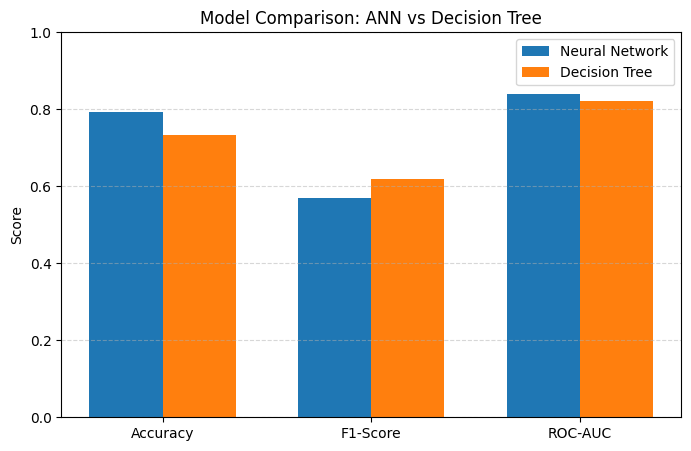

In [54]:
# Metrics to compare
metrics = ['Accuracy', 'F1-Score', 'ROC-AUC']

# ANN metric values
ann_values = [
    metrics_nn['Accuracy'],
    metrics_nn['F1-Score'],
    metrics_nn['ROC-AUC']
]

# Decision Tree metric values
dt_values = [
    metrics_dt['Accuracy'],
    metrics_dt['F1-Score'],
    metrics_dt['ROC-AUC']
]

# Bar positions
x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(8,5))

# Create bars
plt.bar(x - width/2, ann_values, width, label='Neural Network')
plt.bar(x + width/2, dt_values, width, label='Decision Tree')

# Labels & formatting
plt.xticks(x, metrics)
plt.ylabel('Score')
plt.title('Model Comparison: ANN vs Decision Tree')
plt.ylim(0, 1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
